In [8]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size'] = 12

In [269]:
variables = ['po','temp','u', 'u_air_t', 'occu', 'temp_out']
datas = {}
temp_out = np.load('../utils/sf_out_temp.npz')['out_temp']
for var in variables:
    data = []
    datay = []
    for i, file in enumerate(['data/ODE/train_maxflow.npz','data/ODE/train_nocontrol.npz', 'data/ODE/train_random_0.npz', 'data/ODE/train_random_1.npz']):
        df = np.load(file)
        if var == 'po':
            datay.append(df[var][1:, 30, 5]-df[var][:-1, 30, 5])
            data.append(df[var][:-1, 30, 5])
        elif var == 'temp':
            datay.append(df[var][1:].mean(axis=-1).mean(axis=-1)-df[var][:-1].mean(axis=-1).mean(axis=-1))
            data.append(df[var][:-1].mean(axis=-1).mean(axis=-1))
        elif var == 'temp_out':
            data.append(temp_out[:-1])
        else: data.append(df[var][:-1])
    datas[var] = np.concatenate(data)
    if var in ['po', 'temp']:
        datas[var+'y'] = np.concatenate(datay)
X1 = np.stack([(400-datas['po'])*datas['u'],  datas['occu']], axis=1)
y1 = datas['poy']
X2 = np.stack([(datas['u_air_t']-datas['temp'])*datas['u'],datas['occu'], datas['temp_out']-datas['temp']], axis=1)
y2 = datas['tempy']


reg_po = LinearRegression().fit(X1[360:],y1[360:])
reg_po.coef_, reg_po.intercept_, reg_po.score(X1,y1)
reg_temp = LinearRegression().fit(X2[:],y2[:])
print('po', reg_po.coef_, reg_po.intercept_, reg_po.score(X1,y1),'\n' \
'temp', reg_temp.coef_, reg_temp.intercept_, reg_temp.score(X2,y2))

po [0.06832239 6.77470751] -9.72105371354668 0.1391519156097708 
temp [0.04557537 0.00401474 0.00110689] -0.0013150380476225558 0.745064659771034


# CO2

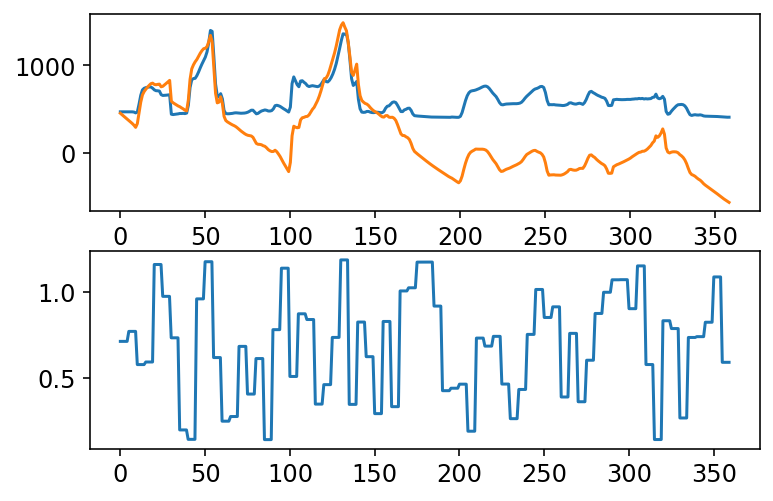

In [266]:
df = np.load('data/ODE/train_random_0.npz')
dpo = 400. - df['po'][1:, 30, 5]
po = df['po'][1:, 30, 5]
du = df['u'][:-1]
doccu = df['occu'][:-1]
feature = [dpo*du,  doccu]
podiff = 0
for i in range(2):  
    podiff += reg_po.coef_[i] * feature[i]
podiff += 1* reg_po.intercept_
fig, ax = plt.subplots(2,1)
ax[0].plot(df['po'][1:, 30, 5],label='true')
ax[0].plot(df['po'][1:, 30, 5]+np.cumsum(podiff), label='predict')
ax[1].plot(df['u'])
#plt.plot(df['u'])

# Temp

(359,) (359,) (359,)


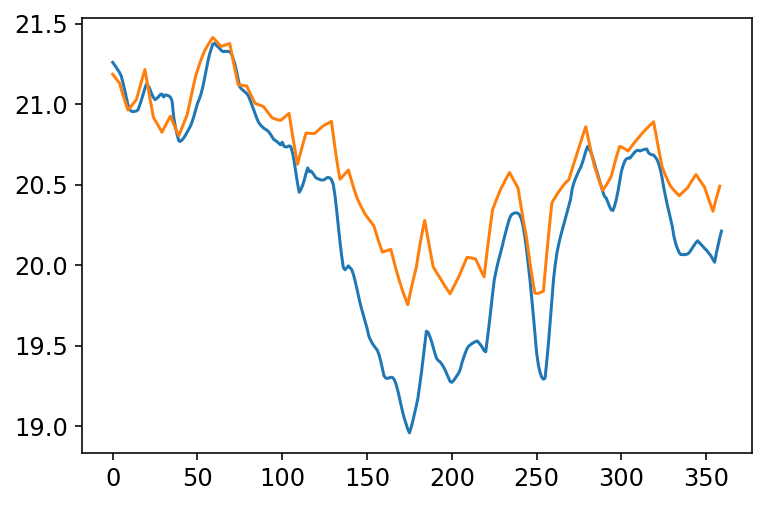

In [262]:
df = np.load('data/ODE/train_random_0.npz')
f1 = (df['u_air_t'][:-1] - df['temp'][:-1].mean(axis=-1).mean(axis=-1))*df['u'][:-1]
f2 = df['occu'][:-1]
f3 = df['temp_out'][:-1]-df['temp'][:-1].mean(axis=-1).mean(axis=-1)
plt.plot(df['temp'][:].mean(axis=-1).mean(axis=-1))
print(f1.shape, f2.shape, f3.shape)
predicted_dt = reg_temp.coef_[0]* f1 + reg_temp.coef_[1]* f2 + reg_temp.coef_[2]* f3 + reg_temp.intercept_
predicted_t = np.cumsum(predicted_dt) + 21.2
plt.plot(predicted_t)
plt.show()

# Optimization

In [270]:
import gurobipy as gp
from gurobipy import GRB

def control_ODE(co20, temp0, occu, T, reg_po, reg_temp):
    m = gp.Model()
    co2 = m.addVars(T, lb=300., ub=1200, name='co2')
    temp = m.addVars(T, lb=16., ub=22.0, name='temp')
    u = m.addVars(T, lb=0.12, ub=1.2, name='u')
    ut = m.addVars(T, lb=21.0, ub=22.0, name='u_air_t')
    m.addConstr(co2[0]==(400.0-co20)*u[0]*reg_po.coef_[0]+occu[0]*reg_po.coef_[1]+400.0)
    m.addConstr(temp[0] == temp0 + (ut[0]-temp0) * u[0] * reg_temp.coef_[0] + occu[0] * reg_temp.coef_[1] + (temp_out[0]-temp0) * reg_temp.coef_[2] + reg_temp.intercept_)
    m.addConstrs(co2[i]==(400.0-co2[i-1])*u[i]*reg_po.coef_[0]+occu[i]*reg_po.coef_[1]+co2[i-1] for i in range(1,T))
    m.addConstrs(temp[i]==temp[i-1] + (ut[i]-temp[i-1]) * u[i] * reg_temp.coef_[0] + occu[i] * reg_temp.coef_[1] + (temp_out[i]-temp[i-1]) * reg_temp.coef_[2] + reg_temp.intercept_ for i in range(1,T))
    objective = 1/60 * gp.quicksum(30 * u[i]+ 3 *(ut[i]-14.44) for i in range(T))
    #objective += 0.5 * gp.quicksum(u[i]-u[i-1]+ut[i]-ut[i-1] for i in range(1,T))
    m.setObjective(objective, GRB.MINIMIZE)
    m.params.NonConvex = 2
    m.setParam('TimeLimit', 100)
    m.optimize()
    result_co2, result_u = np.zeros(T), np.zeros(T)
    result_temp, result_ut = np.zeros(T), np.zeros(T)
    for idx in co2.keys():
        result_co2[idx] = co2[idx].x
        result_u[idx] = u[idx].x
        result_ut[idx] = ut[idx].x
        result_temp[idx] = temp[idx].x
    return result_co2, result_temp, result_u, result_ut

In [271]:
result_co2, result_temp, result_u, result_ut = control_ODE(400.0, 21.2, df['occu'], 360, reg_po, reg_temp)

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 100
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1 rows, 1440 columns and 1 nonzeros
Model fingerprint: 0x09141abc
Model has 719 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [5e-02, 7e-02]
  QLMatrix range   [1e+00, 3e+01]
  Objective range  [5e-02, 5e-01]
  Bounds range     [1e-01, 1e+03]
  RHS range        [4e+02, 4e+02]
  QRHS range       [2e-02, 5e+01]
Presolve removed 1 rows and 1 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 1 rows and 7 columns
Presolve time: 0.01s
Presolved: 4643 rows, 2151 columns, 14284 nonzeros
Presolved model has 1071 bilinear constraint(s)
Variable types: 2151 continuous, 0 integer (0 binary)

Root relaxation: objective 1.766050e+02, 137

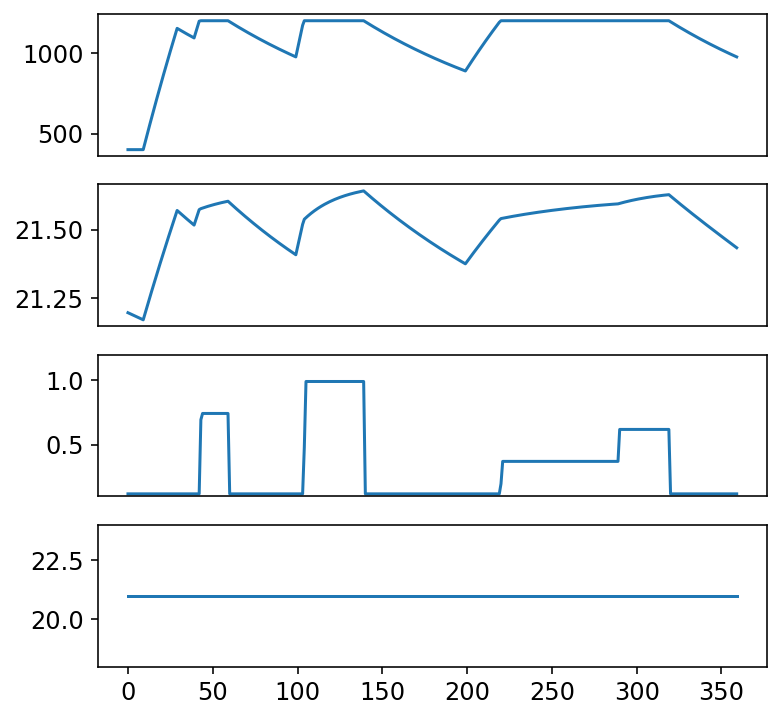

In [273]:
fig, ax = plt.subplots(4,1, figsize=(6,6))
ax[0].plot(result_co2, label='CO2')
ax[1].plot(result_temp, label='Temp')
ax[2].plot(result_u, label='u1')
ax[3].plot(result_ut, label='u2')
ax[2].set_ylim([0.1, 1.2])
ax[3].set_ylim([18, 24])
for i in range(3): ax[i].set_xticks([])
np.savez('data/ODE/solution.npz', result_co2=result_co2, result_temp=result_temp, u=result_u, u_air_t=result_ut)
plt.show()